# MNIST Classification using RBF-KAN (Radial Basis Function-based Kolmogorov-Arnold Networks)

This notebook demonstrates the implementation and training of a RBF-KAN model for the MNIST handwritten digit classification task. The experiment uses the FasterKAN implementation from the `kan_utils` module.

## Overview

1. **Data Preparation**: Load and preprocess the MNIST dataset
2. **Model Setup**: Initialize a FasterKAN model with appropriate architecture
3. **Training**: Train the model with validation
4. **Evaluation**: Evaluate the model on test data
5. **Visualization**: Plot training metrics and model predictions

# Settings

Before running this notebook, you can adjust the following settings to customize the experiment.

In [ ]:
import os
import torch

# Settings for dataset download
DATASET_ROOT = './data'  # Default location to download the MNIST dataset
# Alternatively, you can use a custom path: 
# DATASET_ROOT =

# Create the directory if it doesn't exist
os.makedirs(DATASET_ROOT, exist_ok=True)

# Check if MNIST dataset already exists in the default location
mnist_train_path = os.path.join(DATASET_ROOT, 'MNIST', 'raw', 'train-images-idx3-ubyte')
mnist_test_path = os.path.join(DATASET_ROOT, 'MNIST', 'raw', 'test-images-idx3-ubyte')

if os.path.exists(mnist_train_path) and os.path.exists(mnist_test_path):
    print(f"MNIST dataset already exists at: {os.path.abspath(os.path.join(DATASET_ROOT, 'MNIST'))}")
    print(f"   Train images: {os.path.getsize(mnist_train_path) / (1024*1024):.2f} MB")
    print(f"   Test images: {os.path.getsize(mnist_test_path) / (1024*1024):.2f} MB")
else:
    print(f"MNIST dataset will be downloaded to: {os.path.abspath(DATASET_ROOT)}")

# Other global settings
USE_CUDA = torch.cuda.is_available()  # Automatically use CUDA if available
RANDOM_SEED = 42                      # Random seed for reproducibility

MNIST dataset will be downloaded to: C:\Users\mrlnp\OneDrive - National and Kapodistrian University of Athens\Υπολογιστής\KANs\mnist\MNIST\Dataset


In [ ]:
# Import required libraries
import os
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, classification_report

# Ensure the parent directory is in the path to import kan_utils
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
    print(f"Added {parent_dir} to sys.path")

# After fixing local imports to use relative imports, we need to import from the package
try:
    # Import KAN utilities
    from kan_utils.fasterkan import FasterKAN
    from kan_utils.training import initialize_kan_model_from_config, train_and_validate_model, validate_model
    from kan_utils.general_utils import load_json, count_parameters, get_model_macs_params
    from kan_utils.plotter import loss_plotter, accuracy_plotter, plot_confusion_matrix
except ImportError as e:
    print(f"Import error: {e}")

# Set device based on settings
device = torch.device('cuda' if torch.cuda.is_available() and USE_CUDA else 'cpu')
print(f"Using device: {device}")

Added c:\Users\mrlnp\OneDrive - National and Kapodistrian University of Athens\Υπολογιστής\KANs\Radial-Basis-Function-Based-Kolmogorov-Arnold-Networks to sys.path
Using device: cpu


## 1. Data Preparation

We'll load the MNIST dataset using torchvision and prepare it for training:

In [3]:
# Load configuration
config_path = 'config.json'
config = load_json(config_path)

# Set random seeds for reproducibility
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

# Data transformation
transform = transforms.Compose([
    transforms.Resize((config['x_dim'], config['y_dim'])),  # Resize to match model input dimensions
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

# Load MNIST dataset using the specified root directory
train_dataset = datasets.MNIST(
    root=DATASET_ROOT, 
    train=True, 
    download=True, 
    transform=transform
)

test_dataset = datasets.MNIST(
    root=DATASET_ROOT, 
    train=False, 
    download=True, 
    transform=transform
)

# Split training data into train and validation sets (80% train, 20% validation)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=config['batch_size'], 
    shuffle=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=config['batch_size'], 
    shuffle=False
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=config['batch_size'], 
    shuffle=False
)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Number of batches in training loader: {len(train_loader)}")
print(f"Number of batches in validation loader: {len(val_loader)}")
print(f"Number of classes: {config['output_classes']}")

Train dataset size: 48000
Validation dataset size: 12000
Test dataset size: 10000
Number of batches in training loader: 375
Number of batches in validation loader: 94
Number of classes: 10


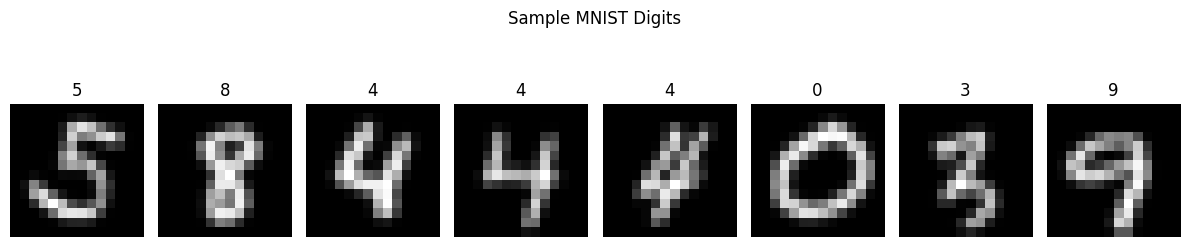

In [4]:
# Visualize some sample images
def imshow(img):
    """Display a PyTorch tensor as an image."""
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    
    # Handle different image dimensions:
    # If the image is a single-channel grayscale image (which MNIST is)
    if npimg.ndim == 2:
        plt.imshow(npimg, cmap='gray')
    elif npimg.ndim == 3 and npimg.shape[0] == 1:  # Batched single-channel
        plt.imshow(npimg.squeeze(), cmap='gray')
    else:  # RGB or other multi-channel image
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
    plt.axis('off')

# Get random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
plt.figure(figsize=(12, 3))
for i in range(8):
    plt.subplot(1, 8, i + 1)
    imshow(images[i].squeeze())
    plt.title(str(labels[i].item()))
plt.suptitle("Sample MNIST Digits")
plt.tight_layout()
plt.show()

## 2. Model Setup

Now let's initialize our FasterKAN model using the configuration from `config.json`:

In [5]:
# Initialize model from config
model, checkpoint_dir = initialize_kan_model_from_config(config_path, device=device)

# Alternative direct initialization (if you want to customize the model)
'''
model = FasterKAN(
    layers_hidden=config['dim_list'],
    num_grids=config['grid_size_per_layer'],
    grid_min=config['grid_min'],
    grid_max=config['grid_max'],
    inv_denominator=config['inv_denominator']
).to(device)
'''

# Print model summary
total_params, trainable_params = count_parameters(model)
print(f"Model architecture: {model}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Calculate MACs (if possible)
macs, _, _ = get_model_macs_params(model, config)
if macs:
    print(f"MACs: {macs:,}")

# Ensure checkpoint directory exists
os.makedirs(checkpoint_dir, exist_ok=True)
print(f"Checkpoint directory: {checkpoint_dir}")

[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               RSF-1               [-1, 196, 4]               0
           Dropout-2                  [-1, 784]               0
            Linear-3                  [-1, 128]         100,352
    FasterKANLayer-4                  [-1, 128]               0
               RSF-5               [-1, 128, 4]               0
           Dropout-6                  [-1, 512]               0
            Linear-7                   [-1, 10]           5,120
    FasterKANLayer-8                   [-1, 10]               0
Total params: 105,472
Trainable params: 105,472
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params siz

## 3. Training

Now we'll train the model using the `train_and_validate_model` function from the `kan_utils` module:

In [ ]:
# Train the model
train_history = train_and_validate_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=config['criterion'],
    optimizer=config['optimizer'],
    scheduler=config.get('scheduler'),
    learning_rate=config.get('learning_rate'),
    device=device,
    checkpoint_dir=checkpoint_dir,
    epochs=15,
    patience=config.get('scheduler_patience', 5),
    early_stopping=True,
    scheduler_params={
        'factor': config.get('scheduler_factor', 0.5),
        'patience': config.get('scheduler_patience', 5),
        'verbose': True
    },
    save_every=5,  # Save model checkpoint every 5 epochs,
    use_one_hot=False # Whether to use one-hot encoding for targets, not needed for CrossEntropyLoss
)

## 4. Visualization

Let's visualize the training results:

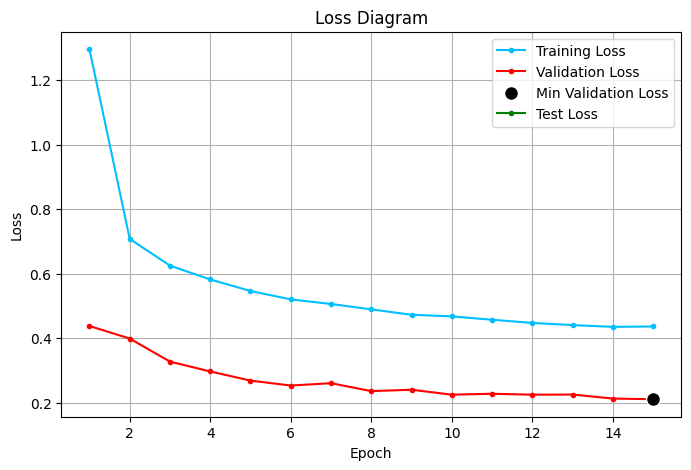

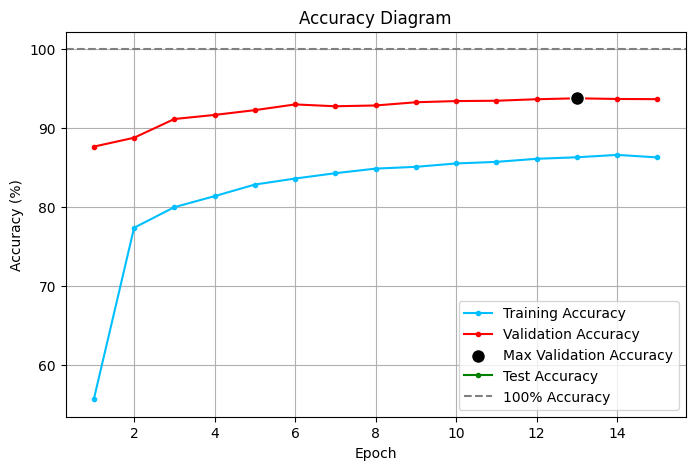

In [7]:
# Plot training and validation loss
loss_plotter(dir_path = checkpoint_dir, show_hyperparams=False)
accuracy_plotter(dir_path = checkpoint_dir, show_hyperparams=False)

## 5. Model Evaluation

Let's evaluate our model on the test dataset:

In [15]:
# Load the best model checkpoint
best_checkpoint = os.path.join(checkpoint_dir, 'best', 'model_checkpoint.pth')
val_loss, val_accuracy = validate_model(
        model=model,
        val_loader=test_loader,
        criterion=config['criterion'],
        checkpoint_path=best_checkpoint,
        device=device,
        metrics_flag=True
    )

Checkpoint loaded from Training Checkpoints\CrossEntropyLoss_AdamW_ReduceLROnPlateau_0.003_[4]_c4165b3a\best\model_checkpoint.pth. Next epoch is 15.
Model loaded from checkpoint: Training Checkpoints\CrossEntropyLoss_AdamW_ReduceLROnPlateau_0.003_[4]_c4165b3a\best\model_checkpoint.pth


Validating:   0%|          | 0/79 [00:00<?, ?batch/s]

F1 Score: 0.9422
Recall: 0.9423
Accuracy: 94.23%
Confusion Matrix:
[[ 963    0    1    0    0    1    6    1    8    0]
 [   0 1118    6    1    0    1    2    0    7    0]
 [   9    4  987    1    6    0    2   15    7    1]
 [   1   12   10  935    0    4    0   17   24    7]
 [   1    5    3    0  884    1   14    3    4   67]
 [   7    4    0   42    4  793   14    1   20    7]
 [   7    7    0    0    3    4  933    0    4    0]
 [   1   20   11    2    2    0    0  976    0   16]
 [  15    6    6    9    7    3    5    8  902   13]
 [   9   10    1   12   16    0    1   18   10  932]]


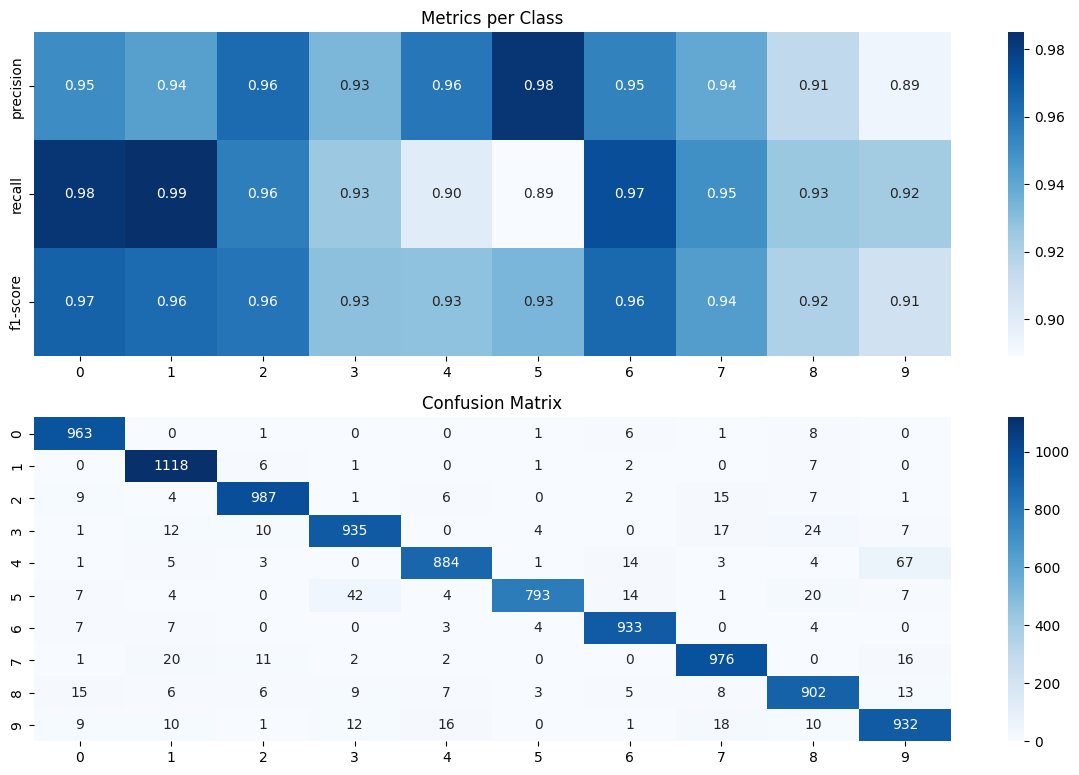

In [16]:
# Now collect predictions
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output, 1)
        
        y_true.extend(target.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
y_true = np.array(y_true)
y_pred = np.array(y_pred)

class_names = [str(i) for i in range(10)]
plot_confusion_matrix(y_true, y_pred, class_names)

In [17]:
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
pd.DataFrame(report)

,0,1,2,3,4,5,6,7,8,9,accuracy,macro avg,weighted avg
precision,0.950642,0.942664,0.962927,0.933134,0.958785,0.982652,0.954964,0.939365,0.914807,0.893576,0.9423,0.943352,0.942897
recall,0.982653,0.985022,0.956395,0.925743,0.900204,0.889013,0.973904,0.949416,0.926078,0.923687,0.9423,0.941212,0.942300
f1-score,0.966382,0.963378,0.959650,0.929423,0.928571,0.933490,0.964341,0.944364,0.920408,0.908382,0.9423,0.941839,0.942178
support,980.000000,1135.000000,1032.000000,1010.000000,982.000000,892.000000,958.000000,1028.000000,974.000000,1009.000000,0.9423,10000.000000,10000.000000


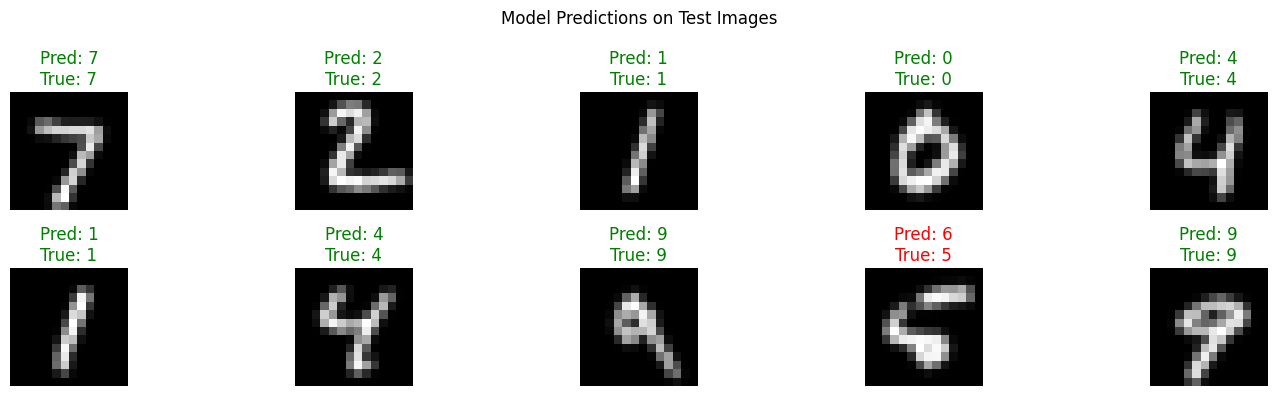

In [18]:
# Display some sample predictions
def show_predictions(model, data_loader, device, num_samples=10):
    """Show model predictions on sample images."""
    model.eval()
    dataiter = iter(data_loader)
    images, labels = next(dataiter)
    
    # Make predictions
    with torch.no_grad():
        images = images.to(device)
        outputs = model(images.view(images.size(0), -1))
        _, predicted = torch.max(outputs, 1)
    
    # Plot images with predictions
    plt.figure(figsize=(15, 4))
    for i in range(num_samples):
        plt.subplot(2, 5, i + 1)
        imshow(images[i].cpu().squeeze())
        color = 'green' if predicted[i] == labels[i] else 'red'
        plt.title(f'Pred: {predicted[i].item()}\nTrue: {labels[i].item()}', color=color)
    
    plt.suptitle("Model Predictions on Test Images")
    plt.tight_layout()
    plt.show()

# Show some predictions
try:
    show_predictions(model, test_loader, device)
except Exception as e:
    print(f"Error displaying predictions: {e}")

## 6. Conclusion

In this notebook, we have:

1. Loaded and prepared the MNIST dataset
2. Initialized a FasterKAN model with a [196, 128, 10] architecture
3. Trained the model for 15 epochs only
4. Visualized the training metrics
5. Evaluated the best model on the test dataset and managed to get 94.23% accuracy
6. Displayed sample predictions

The RBF-KAN model demonstrates effective performance on the MNIST digit classification task. The architecture's unique use of radial basis functions provides an alternative approach to traditional neural networks.

### Next Steps

- Experiment with different hyperparameters (grid size, dimensions, etc.)
- Try model quantization (see `mnist_kan_quant.ipynb`)
- Compare with other model architectures